# Trademark ducky dataset Phase Retrieval

> Georgios Varnavides | Oct 23 2025  
>
> Sample: graphene substrate ducky  
> Sampling conditions: 4 Ang step-sizes  
> Imaging conditions: 20 mrad, 500 A  

In [1]:
import quantem as em
import numpy as np

In [2]:
dataset = em.core.io.load("../data/ducky_20mrad_500A-df_4A-step.zip")
dataset

Dataset(shape=(41, 41, 200, 200), dtype=float32, name='4D-STEM dataset')
  sampling: [4.         4.         1.04392901 1.04392901]
  units: ['A', 'A', 'mrad', 'mrad']
  signal units: 'arb. units'

In [3]:
energy = 80e3
semiangle_cutoff = 20
defocus = 500
rotation_angle = np.deg2rad(-15)

In [4]:
def add_poisson_noise(
    dataset,
    electrons_per_area,
):
    if electrons_per_area == np.inf:
        return dataset
    electrons_per_probe = electrons_per_area * dataset.sampling[:2].prod()
    
    dataset_noisy = dataset.copy()
    dataset_noisy.array = np.random.poisson(dataset.array * electrons_per_probe)
    return dataset_noisy

In [5]:
np.random.seed(2025)
noisy_dataset = add_poisson_noise(
    dataset,
    1e5
)

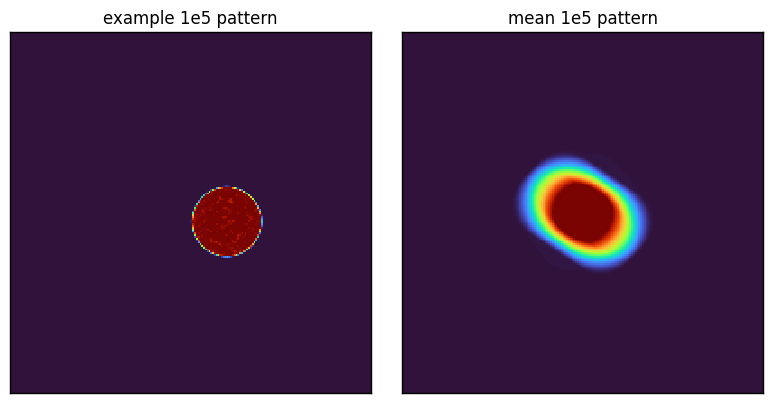

In [7]:
# notice the descan!
em.visualization.show_2d(
    [
        noisy_dataset[0,0].array,
        noisy_dataset.mean((0,1)),
    ],
    title=[
        "example 1e5 pattern","mean 1e5 pattern"
    ],
    power=0.5,
    cmap='turbo'
);

In [8]:
direct_ptycho = em.diffractive_imaging.DirectPtychography.from_dataset4d(
    noisy_dataset,
    energy=energy,
    semiangle_cutoff=semiangle_cutoff,
    rotation_angle=rotation_angle,
    aberration_coefs={"defocus":defocus},
    device='gpu',
)

  0%|          | 0/6 [00:00<?, ?it/s]

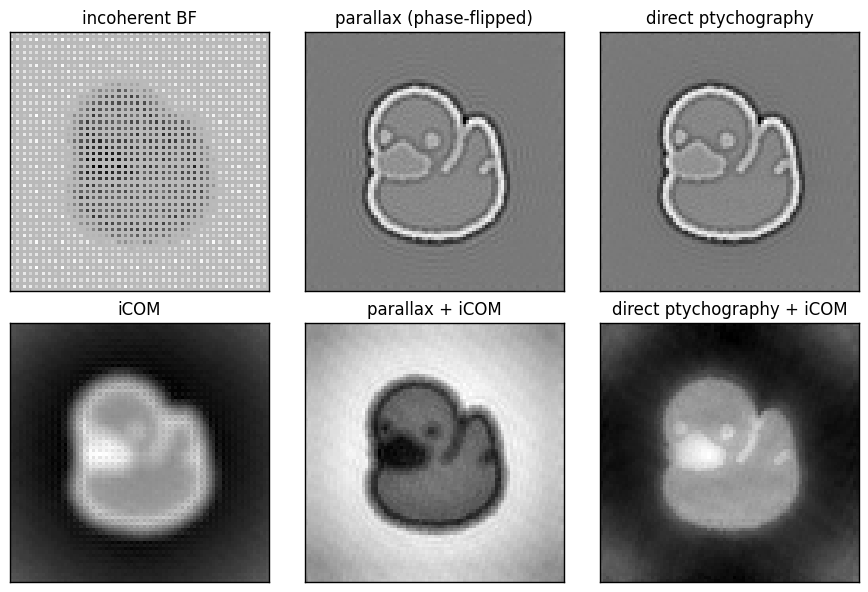

In [9]:
kwargs = {
    "title":[
        ["incoherent BF","parallax (phase-flipped)","direct ptychography",],
        ["iCOM","parallax + iCOM", "direct ptychography + iCOM"]
    ],
    "norm":"minmax",
    "axsize":(3,3),
}

recons = direct_ptycho._reconstruct_all_permutations(
    upsampling_factor=2,
)

em.visualization.show_2d(
    [
        recons[:3],
        recons[3:],
    ],
    **kwargs
);

  0%|          | 0/250 [00:00<?, ?it/s]

Optimized parameters: {'defocus': 521.9053651186621}


  0%|          | 0/1153 [00:00<?, ?it/s]

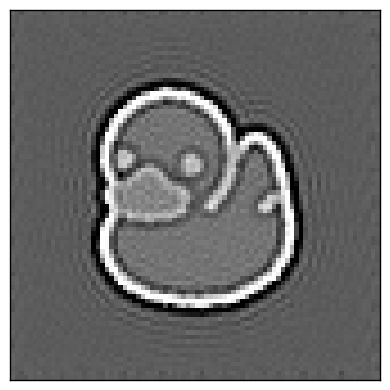

In [10]:
# Optimize defocus with optuna
direct_ptycho = direct_ptycho.optimize_hyperparameters(
    aberration_coefs={
        "defocus":em.diffractive_imaging.direct_ptychography.OptimizationParameter(
            0,1000
        )
    },
    n_trials=250,
    deconvolution_kernel='parallax',
)

em.visualization.show_2d(
    direct_ptycho.reconstruct_with_optimized_parameters(
        deconvolution_kernel='parallax',
        upsampling_factor=2,
    ).obj
);

Aligning (reference):   0%|          | 0/5 [00:00<?, ?it/s]

Fitted parameters: {'C10': -529.3758544921875, 'C12': 0.6091160178184509, 'phi12': -0.03894465044140816, 'rotation_angle': -0.2626831531524658}


  0%|          | 0/1153 [00:00<?, ?it/s]

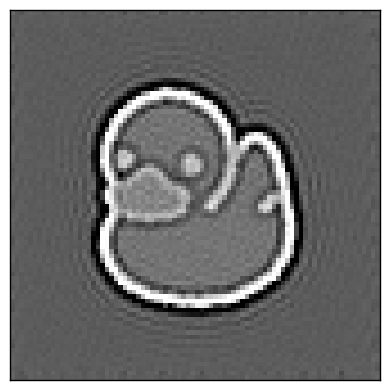

In [11]:
# reference fit from scratch (note the aberration_coeffs = {} and rotation_angle=0.0 arguments overriding init values)
direct_ptycho.fit_hyperparameters(
    alignment_method='reference',
    bin_factors=(3,2,1,1,1),

    # reset aberrations and rotation to prove it can find it from scratch.
    # in practice, you should pass a good guess, either here or (preferably) during initialization
    aberration_coefs = {},
    rotation_angle= 0.0,
);

em.visualization.show_2d(
    direct_ptycho.reconstruct_with_fitted_parameters(
        deconvolution_kernel='parallax',
        upsampling_factor=2,
    ).obj
);